## Machine Learning Models

Using MPS device for GPU acceleration on Apple Silicon.
Connected to database quantummusic. (fetch-only)
Database connection closed.
Epoch 1/10: train_loss=3.6152, test_loss=3.4747
Epoch 2/10: train_loss=3.1245, test_loss=2.7733
Epoch 3/10: train_loss=2.8893, test_loss=2.6711
Epoch 4/10: train_loss=2.6898, test_loss=2.7703
Epoch 5/10: train_loss=2.5532, test_loss=2.9384
Epoch 6/10: train_loss=2.7286, test_loss=2.7574
Epoch 7/10: train_loss=2.5306, test_loss=2.7304
Epoch 8/10: train_loss=2.3620, test_loss=2.9151
No improvement for 5 epochs after epoch 5. Stopping at epoch 8.
Training complete or early stopped.
Loading best model state (lowest test loss).


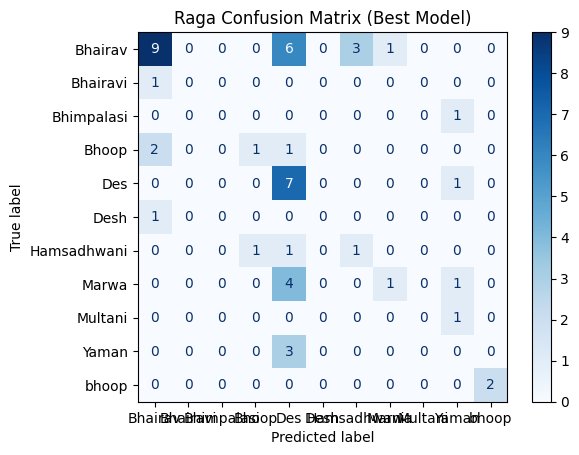

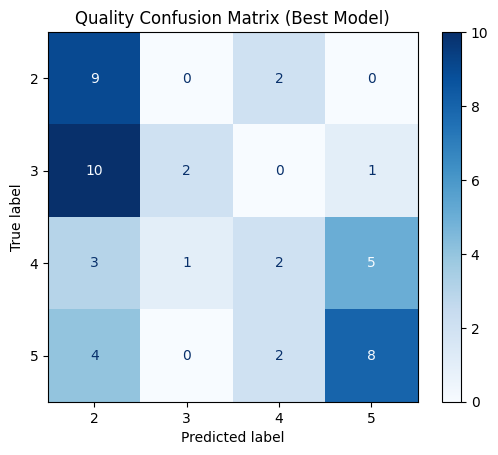

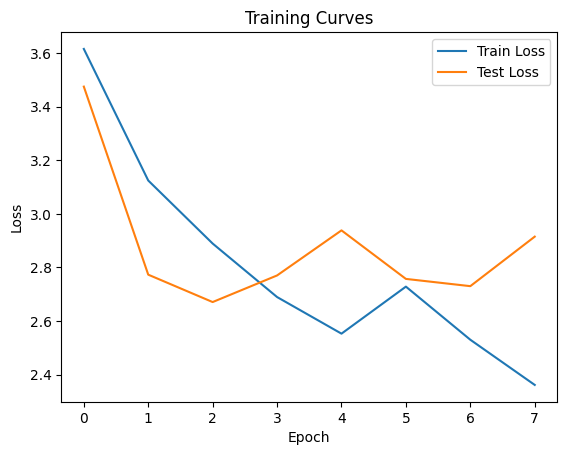

Best model + metadata + used_ids saved to: data/modeloutput/trained_model.pt


In [3]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

from transformers import ASTModel, ASTConfig
import torchvision.transforms as T
from PIL import Image


# MPS DEVICE CHECK

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS device for GPU acceleration on Apple Silicon.")
else:
    DEVICE = torch.device("cpu")
    print("MPS not available. Falling back to CPU.")


# HYPERPARAMETERS / GLOBAL SETTINGS
HYPERPARAMS = {
    "OUTPUT_DIR": "data/trainingdataoutput",
    "DB_LIMIT": 1000,               # We'll read up to 1000 records from DB
    "BATCH_SIZE": 8,
    "EPOCHS": 10,                   # up to 10 or 20 epochs
    "LEARNING_RATE_MAIN": 5e-5,     # for AST layers
    "LEARNING_RATE_HEAD": 1e-4,     # for scalar/quantum/final layers
    "WEIGHT_DECAY": 1e-4,           # L2 regularization
    "DEVICE": DEVICE,
    "NUM_AST_LAYERS_UNFROZEN": 4,   # partial unfreezing
    "PATIENCE": 5,                  # early stopping patience
    "STOP_LIMIT": 5,                # must train at least this many epochs

    # AST model input shape for audio: (freq=128, time=1024) by default
    "AST_FREQ": 128,
    "AST_TIME": 1024
}


# Minimal DB
class QuantumMusicDBFetchOnly:
    def __init__(self, db_name="quantummusic", host="localhost", user="postgres", password="postgres"):
        import psycopg2
        self.psycopg2 = psycopg2
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            import psycopg2
            self.conn = psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name}. (fetch-only)")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

    def fetch_limited_analysis_data(self, limit=1000):
        """
        You can customize this query as needed.
        """
        with self.conn.cursor() as cur:
            query = """
                WITH cte AS (
                    SELECT
                        id,
                        analysis_data,
                        substring(file_name FROM '\\d+')::int AS file_num,
                        ROW_NUMBER() OVER (
                            PARTITION BY substring(file_name FROM '\\d+')::int
                            ORDER BY random()
                        ) AS rn
                    FROM audio_analysis
                    WHERE substring(file_name FROM '\\d+')::int IN (2, 3, 4, 5)
                )
                SELECT id, analysis_data
                FROM cte
                WHERE rn <= 66;
            """
            cur.execute(query)
            rows = cur.fetchall()
        return rows

    def fetch_single_record(self, record_id):
        with self.conn.cursor() as cur:
            query = "SELECT id, analysis_data FROM audio_analysis WHERE id = %s"
            cur.execute(query, (record_id,))
            row = cur.fetchone()
        return row

    def fetch_leftover_records(self, exclude_ids):
        """
        Fetch records not in exclude_ids, with rating >=4 based on parse_raga_and_quality.
        We'll fetch from the entire table or some subset.
        """
        with self.conn.cursor() as cur:
            q = "SELECT id, analysis_data FROM audio_analysis"
            cur.execute(q)
            rows = cur.fetchall()

        leftover = []
        for r_id, analysis_data in rows:
            if r_id in exclude_ids:
                continue
            fname = analysis_data["file_name"]
            base = fname.replace(".wav", "")
            m = re.match(r"^([A-Za-z]+)([1-5])(.*)", base)
            if m:
                rating = int(m.group(2))
                if rating >= 4:
                    leftover.append((r_id, analysis_data))
        return leftover


# Convert quantum measurement counts -> probability vector
def convert_counts_to_probs_feature(counts_dict, max_bits=10):
    total_counts = sum(counts_dict.values())
    if total_counts == 0:
        return np.zeros(2**max_bits, dtype=np.float32)

    feature_vec = np.zeros(2**max_bits, dtype=np.float32)
    for bitstring, c in counts_dict.items():
        if len(bitstring) > max_bits:
            truncated = bitstring[-max_bits:]
        else:
            truncated = bitstring.rjust(max_bits, '0')
        idx = int(truncated, 2)
        feature_vec[idx] += c / total_counts
    return feature_vec


def parse_raga_and_quality(fname: str):
    """
    Using filename format: <RagaName><rating>[optional extras].wav
    e.g. Bhairavi4_run2.wav => raga=Bhairavi, rating=4
    """
    base = fname.replace(".wav", "")
    m = re.match(r"^([A-Za-z]+)([1-5])(.*)", base)
    if not m:
        return None, None
    raga = m.group(1)
    rating = int(m.group(2))
    return raga, rating


# We include a Resize so all images have shape (1,128,128):
transform_img = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

def load_image_as_tensor(image_path: str):
    if not os.path.exists(image_path):
        return None
    with Image.open(image_path) as img:
        # Convert to mono, then resize & convert to Tensor.
        img = img.convert("L")
        return transform_img(img)  # => shape [1,128,128]


###############################################################################
# fetch_training_data_v2
###############################################################################
def fetch_training_data_v2(limit=None):
    """
    This function fetches data from the DB, parses the new JSON structure,
    and extracts scalar + quantum features plus a single Mel-spectrogram image.
    The rest of the pipeline remains mostly unchanged.
    """
    db = QuantumMusicDBFetchOnly()
    rows = db.fetch_limited_analysis_data(limit=limit or HYPERPARAMS["DB_LIMIT"])
    db.close()

    if not rows:
        print("No data found in DB.")
        return None, []

    # We'll store:
    #   1) images_mel   : shape (1, 128, 128)
    #   2) scalar_feats : from summary/time_matrices
    #   3) quantum_feats: angles + measurement_counts
    #   4) labels_raga, labels_quality
    #   5) used_ids     : track DB row IDs used

    images_mel = []
    scalar_feats = []
    quantum_feats = []
    labels_raga = []
    labels_quality = []
    used_ids = []

    for (record_id, analysis_data) in rows:
        used_ids.append(record_id)

        # Identify raga, quality from the filename
        fname = analysis_data["file_name"]
        raga, quality = parse_raga_and_quality(fname)
        if raga is None or quality is None:
            continue

        base_no_ext = fname.replace(".wav", "")
        # Single image: Mel-spectrogram => <basename>_mel.png
        mel_path = os.path.join("data", "analysisoutput", f"{base_no_ext}_mel.png")
        mel_img = load_image_as_tensor(mel_path)

        # Provide a fallback if not found => shape [1,128,128]
        if mel_img is None:
            mel_img = torch.zeros((1, 128, 128))

        images_mel.append(mel_img)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Pull out features from the new JSON structure
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        summary_dict = analysis_data.get("summary", {})
        pitch_dev    = summary_dict.get("pitch_deviation", {})
        tnr_dict     = summary_dict.get("tone_to_noise_ratio", {})
        praat_dict   = summary_dict.get("praat", {})
        dynamics     = summary_dict.get("dynamics", {})

        # Pitch deviation => mean, std
        avg_dev = pitch_dev.get("mean", 0.0)
        std_dev = pitch_dev.get("std", 0.0)

        # Tone-to-noise ratio => mean
        avg_tnr = tnr_dict.get("mean", 0.0)

        # Praat => hnr_mean
        avg_hnr = praat_dict.get("hnr_mean", 0.0)

        # RMS & LUFS
        rms_db_stats = dynamics.get("rms_db", {})
        mean_rms_db  = rms_db_stats.get("mean", 0.0)
        lufs_stats   = dynamics.get("lufs", {})
        mean_lufs    = lufs_stats.get("mean", 0.0)

        # time_matrix_small => jitter, shimmer, vibrato, F1
        time_matrices = analysis_data.get("time_matrices", {})
        time_matrix_small = time_matrices.get("time_matrix_small", [])

        jitter_vals = [entry.get("jitter", 0.0) for entry in time_matrix_small]
        avg_jitter  = float(np.mean(jitter_vals)) if len(jitter_vals) > 0 else 0.0

        shimmer_vals = [entry.get("shimmer", 0.0) for entry in time_matrix_small]
        avg_shimmer  = float(np.mean(shimmer_vals)) if len(shimmer_vals) > 0 else 0.0

        vib_vals = [entry.get("vibrato_rate", 0.0) for entry in time_matrix_small]
        avg_vibrato = float(np.mean(vib_vals)) if len(vib_vals) > 0 else 0.0

        f1_vals = [entry.get("formants", {}).get("F1", 0.0) for entry in time_matrix_small]
        avg_formant = float(np.mean(f1_vals)) if len(f1_vals) > 0 else 0.0

        # Combine scalar features
        scalars = [
            avg_dev, std_dev,       # pitch_deviation
            avg_hnr, avg_tnr,       # HNR, TNR
            mean_rms_db, mean_lufs, # overall loudness/dynamics
            avg_jitter, avg_shimmer, avg_vibrato, avg_formant
        ]

        # Quantum features
        quantum_dict = analysis_data.get("quantum_analysis", {})
        angles = quantum_dict.get("scaled_angles", [])
        max_len = 10
        angle_arr = np.zeros(max_len, dtype=np.float32)
        for i in range(min(max_len, len(angles))):
            angle_arr[i] = angles[i]

        counts_d = quantum_dict.get("measurement_counts", {})
        dist_vec = convert_counts_to_probs_feature(counts_d, max_bits=10)
        combined_q = np.concatenate([angle_arr, dist_vec], axis=0)

        scalar_feats.append(scalars)
        quantum_feats.append(combined_q)
        labels_raga.append(raga)
        labels_quality.append(quality)

    # Stack everything
    images_mel    = torch.stack(images_mel)  # shape => (N, 1, 128, 128)
    scalar_feats  = np.array(scalar_feats, dtype=np.float32)
    quantum_feats = np.array(quantum_feats, dtype=np.float32)

    unique_ragas  = sorted(list(set(labels_raga)))
    raga_to_idx   = {r: i for i, r in enumerate(unique_ragas)}
    label_raga_idx = [raga_to_idx[r] for r in labels_raga]
    label_quality_idx = np.array([q - 1 for q in labels_quality], dtype=np.int64)

    data_dict = {
        "images_mel": images_mel,
        "scalar_feats": scalar_feats,
        "quantum_feats": quantum_feats,
        "label_raga_idx": np.array(label_raga_idx, dtype=np.int64),
        "label_quality": label_quality_idx,
        "raga_to_idx": raga_to_idx,
        "unique_ragas": unique_ragas
    }

    return data_dict, used_ids


###############################################################################
# DATASET & MODEL (USING THE AUDIO SPECTROGRAM TRANSFORMER)
###############################################################################

class MultiLabelASTDataset(Dataset):
    """
    We store:
       1) mel_imgs
       2) scalar, quantum arrays
       3) raga, quality labels
    """
    def __init__(self, data_dict):
        self.mel_imgs   = data_dict["images_mel"]
        self.scalars    = data_dict["scalar_feats"]
        self.quants     = data_dict["quantum_feats"]
        self.raga_lbl   = data_dict["label_raga_idx"]
        self.qual_lbl   = data_dict["label_quality"]

    def __len__(self):
        return len(self.raga_lbl)

    def __getitem__(self, idx):
        scal  = torch.tensor(self.scalars[idx], dtype=torch.float32)
        quan  = torch.tensor(self.quants[idx], dtype=torch.float32)
        rag   = torch.tensor(self.raga_lbl[idx], dtype=torch.long)
        qual  = torch.tensor(self.qual_lbl[idx], dtype=torch.long)
        return (
            self.mel_imgs[idx],
            scal,
            quan,
            rag,
            qual
        )


class HybridASTModelV2(nn.Module):
    """
    Updated to take a single 'mel_img' rather than separate mfcc/log.
    We resize mel_img to (AST_FREQ x AST_TIME) and feed it to the AST.
    Then we fuse scalar + quantum MLP embeddings, produce raga & quality outputs.
    """
    def __init__(self, num_ragas, scalar_dim=11, quantum_dim=(10 + 2**10), num_quality=5, num_unfrozen_layers=0):
        super().__init__()
        # Load AST config + model
        self.config = ASTConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.ast_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", config=self.config)

        # Partial unfreeze: freeze everything, unfreeze last N encoder layers
        for param in self.ast_model.parameters():
            param.requires_grad = False
        if num_unfrozen_layers > 0:
            total_layers = 12
            start_layer = max(0, total_layers - num_unfrozen_layers)
            for layer_idx in range(start_layer, total_layers):
                for param in self.ast_model.encoder.layer[layer_idx].parameters():
                    param.requires_grad = True

        # MLP for scalar features
        self.scalar_fc = nn.Sequential(
            nn.Linear(scalar_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # MLP for quantum features
        self.quantum_fc = nn.Sequential(
            nn.Linear(quantum_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # The AST base output is 768 dims
        combined_dim = 768 + 64 + 64

        self.raga_head = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_ragas)
        )
        self.quality_head = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_quality)
        )

    def forward(self, mel_img, scal_in, quan_in):
        # mel_img => (B, 1, 128, 128)
        B, C, H, W = mel_img.shape
        freq = HYPERPARAMS["AST_FREQ"]
        time = HYPERPARAMS["AST_TIME"]

        # Resize to the shape AST expects => (B, 1, 128, 1024)
        mel_resized = F.interpolate(
            mel_img, size=(freq, time),
            mode='bilinear', align_corners=False
        )
        # The AST expects (B, freq, time) with no channel dim => remove channel
        mel_for_ast = mel_resized.squeeze(1)  # (B, 128, 1024)

        outputs = self.ast_model(input_values=mel_for_ast, output_hidden_states=True)
        hidden = outputs.last_hidden_state  # (B, seq_len, 768)
        ast_embedding = hidden[:, 0, :]     # [CLS] => (B, 768)

        emb_scal = self.scalar_fc(scal_in)   # (B, 64)
        emb_quan = self.quantum_fc(quan_in)  # (B, 64)

        fused = torch.cat([ast_embedding, emb_scal, emb_quan], dim=1)  # (B, 768+64+64=896)

        logits_raga    = self.raga_head(fused)    # (B, num_ragas)
        logits_quality = self.quality_head(fused) # (B, 5)

        return logits_raga, logits_quality


###############################################################################
# TRAIN MODEL
###############################################################################
def train_model_v2():
    data_dict, used_ids = fetch_training_data_v2(limit=HYPERPARAMS["DB_LIMIT"])
    if data_dict is None:
        print("No data to train.")
        return None, None

    scalar_feats = data_dict["scalar_feats"]
    quantum_feats = data_dict["quantum_feats"]
    raga_to_idx = data_dict["raga_to_idx"]
    num_ragas = len(raga_to_idx)

    # Build dataset
    dataset_full = MultiLabelASTDataset(data_dict)
    n_samples = len(dataset_full)
    test_size = int(0.2 * n_samples)
    train_size = n_samples - test_size
    train_ds, test_ds = torch.utils.data.random_split(dataset_full, [train_size, test_size])

    train_dl = DataLoader(train_ds, batch_size=HYPERPARAMS["BATCH_SIZE"], shuffle=True)
    test_dl  = DataLoader(test_ds, batch_size=HYPERPARAMS["BATCH_SIZE"], shuffle=False)

    # Build model
    model = HybridASTModelV2(
        num_ragas=num_ragas,
        scalar_dim=scalar_feats.shape[1],
        quantum_dim=quantum_feats.shape[1],
        num_quality=5,
        num_unfrozen_layers=HYPERPARAMS["NUM_AST_LAYERS_UNFROZEN"]
    ).to(HYPERPARAMS["DEVICE"])

    optimizer = optim.Adam(
        model.parameters(),
        lr=HYPERPARAMS["LEARNING_RATE_HEAD"],
        weight_decay=HYPERPARAMS["WEIGHT_DECAY"]
    )
    crit_ce = nn.CrossEntropyLoss()

    EPOCHS = HYPERPARAMS["EPOCHS"]
    train_losses = []
    test_losses = []
    best_test_loss = float("inf")
    best_model_state = None
    patience = HYPERPARAMS["PATIENCE"]
    epochs_no_improve = 0
    stop_limit = HYPERPARAMS["STOP_LIMIT"]

    for epoch in range(EPOCHS):
        # TRAIN
        model.train()
        total_train_loss = 0.0

        for mel_img, scal, quan, rag_lbl, qual_lbl in train_dl:
            mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
            scal    = scal.to(HYPERPARAMS["DEVICE"])
            quan    = quan.to(HYPERPARAMS["DEVICE"])
            rag_lbl = rag_lbl.to(HYPERPARAMS["DEVICE"])
            qual_lbl= qual_lbl.to(HYPERPARAMS["DEVICE"])

            optimizer.zero_grad()
            logits_raga, logits_quality = model(mel_img, scal, quan)
            loss_raga = crit_ce(logits_raga, rag_lbl)
            loss_qual = crit_ce(logits_quality, qual_lbl)
            loss = loss_raga + loss_qual
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dl)
        train_losses.append(avg_train_loss)

        # EVAL
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for mel_img, scal, quan, rag_lbl, qual_lbl in test_dl:
                mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
                scal    = scal.to(HYPERPARAMS["DEVICE"])
                quan    = quan.to(HYPERPARAMS["DEVICE"])
                rag_lbl = rag_lbl.to(HYPERPARAMS["DEVICE"])
                qual_lbl= qual_lbl.to(HYPERPARAMS["DEVICE"])

                logits_raga, logits_quality = model(mel_img, scal, quan)
                loss_raga = crit_ce(logits_raga, rag_lbl)
                loss_qual = crit_ce(logits_quality, qual_lbl)
                total_test_loss += (loss_raga + loss_qual).item()

        avg_test_loss = total_test_loss / len(test_dl)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}: train_loss={avg_train_loss:.4f}, test_loss={avg_test_loss:.4f}")

        # Early Stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if (epoch + 1) >= stop_limit and epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs after epoch {stop_limit}. Stopping at epoch {epoch+1}.")
                break

    print("Training complete or early stopped.")

    # Load best model
    if best_model_state is not None:
        print("Loading best model state (lowest test loss).")
        model.load_state_dict(best_model_state)

    # Evaluate final => confusion matrix
    all_raga_preds, all_raga_truth = [], []
    all_qual_preds, all_qual_truth = [], []

    model.eval()
    with torch.no_grad():
        for mel_img, scal, quan, rag_lbl, qual_lbl in test_dl:
            mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
            scal    = scal.to(HYPERPARAMS["DEVICE"])
            quan    = quan.to(HYPERPARAMS["DEVICE"])
            rag_lbl = rag_lbl.to(HYPERPARAMS["DEVICE"])
            qual_lbl= qual_lbl.to(HYPERPARAMS["DEVICE"])

            logits_raga, logits_quality = model(mel_img, scal, quan)
            pred_raga = logits_raga.argmax(dim=1).cpu().numpy()
            pred_qual = logits_quality.argmax(dim=1).cpu().numpy()

            all_raga_preds.extend(pred_raga)
            all_raga_truth.extend(rag_lbl.cpu().numpy())
            all_qual_preds.extend(pred_qual)
            all_qual_truth.extend(qual_lbl.cpu().numpy())

    cm_raga = confusion_matrix(all_raga_truth, all_raga_preds)
    used_raga_indices = sorted(set(all_raga_truth) | set(all_raga_preds))
    idx_to_raga = {v: k for k, v in raga_to_idx.items()}
    used_raga_labels = [idx_to_raga[i] for i in used_raga_indices]

    disp_raga = ConfusionMatrixDisplay(cm_raga, display_labels=used_raga_labels)
    disp_raga.plot(cmap=plt.cm.Blues)
    plt.title("Raga Confusion Matrix (Best Model)")
    plt.show()

    cm_qual = confusion_matrix(all_qual_truth, all_qual_preds)
    used_qual_indices = sorted(set(all_qual_truth) | set(all_qual_preds))
    used_qual_labels  = [q+1 for q in used_qual_indices]
    disp_qual = ConfusionMatrixDisplay(cm_qual, display_labels=used_qual_labels)
    disp_qual.plot(cmap=plt.cm.Blues)
    plt.title("Quality Confusion Matrix (Best Model)")
    plt.show()

    # Training curves
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curves")
    plt.legend()
    plt.show()

    # Save model + used_ids
    os.makedirs("data/modeloutput", exist_ok=True)
    checkpoint_path = os.path.join("data", "modeloutput", "trained_model.pt")
    checkpoint_dict = {
        "model_state": model.state_dict(),
        "raga_to_idx": data_dict["raga_to_idx"],
        "scalar_dim": scalar_feats.shape[1],
        "quantum_dim": quantum_feats.shape[1],
        "num_ragas": len(data_dict["raga_to_idx"]),
        "used_ids": used_ids
    }
    torch.save(checkpoint_dict, checkpoint_path)
    print(f"Best model + metadata + used_ids saved to: {checkpoint_path}")

    return model, data_dict["raga_to_idx"]


###############################################################################
# SINGLE-RECORD INFERENCE
###############################################################################
def run_inference_on_persisted_model(record_id, model_path="data/modeloutput/trained_model.pt"):
    """
    Single-record inference for quick demos, etc.
    Uses the new JSON structure to parse features. 
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=HYPERPARAMS["DEVICE"])
    model_state = checkpoint["model_state"]
    raga_to_idx = checkpoint["raga_to_idx"]
    scalar_dim  = checkpoint["scalar_dim"]
    quantum_dim = checkpoint["quantum_dim"]
    num_ragas   = checkpoint["num_ragas"]

    # Build the same model
    model = HybridASTModelV2(
        num_ragas=num_ragas,
        scalar_dim=scalar_dim,
        quantum_dim=quantum_dim,
        num_quality=5,
        num_unfrozen_layers=HYPERPARAMS["NUM_AST_LAYERS_UNFROZEN"]
    )
    model.load_state_dict(model_state)
    model.to(HYPERPARAMS["DEVICE"])
    model.eval()

    # Fetch record
    db = QuantumMusicDBFetchOnly()
    row = db.fetch_single_record(record_id)
    db.close()

    if not row:
        print(f"No record found with ID={record_id}")
        return None, None

    _, analysis_data = row
    fname = analysis_data["file_name"]
    raga_true, quality_true = parse_raga_and_quality(fname)
    base_no_ext = fname.replace(".wav", "")

    # Load image => mel
    mel_path = os.path.join("data", "analysisoutput", f"{base_no_ext}_mel.png")
    mel_img = load_image_as_tensor(mel_path)
    if mel_img is None:
        mel_img = torch.zeros((1, 128, 128))

    # Extract scalar feats from new JSON
    summary_dict = analysis_data.get("summary", {})
    pitch_dev    = summary_dict.get("pitch_deviation", {})
    tnr_dict     = summary_dict.get("tone_to_noise_ratio", {})
    praat_dict   = summary_dict.get("praat", {})
    dynamics     = summary_dict.get("dynamics", {})

    avg_dev = pitch_dev.get("mean", 0.0)
    std_dev = pitch_dev.get("std", 0.0)
    avg_tnr = tnr_dict.get("mean", 0.0)
    avg_hnr = praat_dict.get("hnr_mean", 0.0)

    rms_db_stats = dynamics.get("rms_db", {})
    mean_rms_db  = rms_db_stats.get("mean", 0.0)
    lufs_stats   = dynamics.get("lufs", {})
    mean_lufs    = lufs_stats.get("mean", 0.0)

    time_matrices = analysis_data.get("time_matrices", {})
    time_matrix_small = time_matrices.get("time_matrix_small", [])

    jitter_vals = [x.get("jitter", 0.0) for x in time_matrix_small]
    shimmer_vals= [x.get("shimmer", 0.0) for x in time_matrix_small]
    vib_vals    = [x.get("vibrato_rate", 0.0) for x in time_matrix_small]
    f1_vals     = [x.get("formants", {}).get("F1", 0.0) for x in time_matrix_small]

    avg_jitter  = float(np.mean(jitter_vals))  if jitter_vals else 0.0
    avg_shimmer = float(np.mean(shimmer_vals)) if shimmer_vals else 0.0
    avg_vibrato = float(np.mean(vib_vals))      if vib_vals else 0.0
    avg_formant = float(np.mean(f1_vals))      if f1_vals else 0.0

    scalars = [
        avg_dev, std_dev, avg_hnr, avg_tnr,
        mean_rms_db, mean_lufs,
        avg_jitter, avg_shimmer, avg_vibrato, avg_formant
    ]

    # Quantum
    quantum_dict = analysis_data.get("quantum_analysis", {})
    angles = quantum_dict.get("scaled_angles", [])
    max_len = 10
    angle_arr = np.zeros(max_len, dtype=np.float32)
    for i in range(min(max_len, len(angles))):
        angle_arr[i] = angles[i]

    counts_d = quantum_dict.get("measurement_counts", {})
    dist_vec = convert_counts_to_probs_feature(counts_d, max_bits=10)
    combined_q = np.concatenate([angle_arr, dist_vec], axis=0)

    # Prepare for model forward
    device = HYPERPARAMS["DEVICE"]
    mel_img  = mel_img.unsqueeze(0).to(device)  # (1,1,128,128)
    scal_ten = torch.tensor(scalars, dtype=torch.float32).unsqueeze(0).to(device)
    quan_ten = torch.tensor(combined_q, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        logits_raga, logits_quality = model(mel_img, scal_ten, quan_ten)
        pred_raga_idx = torch.argmax(logits_raga, dim=1).item()
        pred_qual_idx = torch.argmax(logits_quality, dim=1).item()

    inv_map = {v: k for k, v in raga_to_idx.items()}
    pred_raga_str = inv_map.get(pred_raga_idx, "UnknownRaga")
    pred_quality = pred_qual_idx + 1

    print(f"Inference for Record ID={record_id}:")
    print(f"  True raga={raga_true}, True quality={quality_true}")
    print(f"  Predicted raga={pred_raga_str}, predicted quality={pred_quality}")
    return pred_raga_str, pred_quality


###############################################################################
# EXAMPLE main section
###############################################################################
if __name__ == "__main__":
    # Example usage:
    model, raga_map = train_model_v2()
    # run_inference_on_persisted_model(2150, "data/modeloutput/trained_model.pt")
    pass